In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import codecs
import os
import re
from tqdm import tqdm
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

# CWT
import math
import pycwt

# 自作関数
import sys
sys.path.append('..')
import sig_proc

In [12]:
def dist_HR(data, peak_times, peak_vals, mode, pre_sample_num = int(0.2*128), post_sample_num = int(0.6*128)):
    """
    R波のピークtoピーク(IBI: Inter-Beat Interval)で心拍データを分けてみる

    Parameters
    ----------
    data : ndarray
        入力データ(1行目ECG, 2行目DOPPLER(I-Q差分)を想定)。
    peak_times : list
        ピーク列(インデックス)。
    peai_vals : list
        ピーク列(値)。
    mode : str
        分割モード指定。'PrePost' or 'IBI'.

    Returns
    -------
    data_out : list of ndarray
        IBIのデータ（ndarray）が格納された配列
    """
    THRESHOLD = 300.0 # これよりピーク値小さいものは異常値として判定することにする(ヒューリスティック)
    
    npeaks = len(peak_times)
    len_data = data.shape[1]
    data_out = []

    if mode == 'PrePost':
        for idx, val in zip(peak_times, peak_vals):
            # not (明らかにR波ピークを誤検出しているもの or ピーク前のデータ数が不足しているもの or ピーク後のデータ数が不足しているもの)
            if val > THRESHOLD and pre_sample_num <= idx <= (len_data - post_sample_num):
                data_temp = data[:,idx-pre_sample_num:idx+post_sample_num]
                data_out.append(data_temp)

    if mode == 'IBI':
        for i in range(npeaks - 1):
            # 明らかにR波ピークを誤検出しているものは触らない
            if peak_vals[i] > THRESHOLD or peak_vals[i+1] > THRESHOLD:
                data_temp = data[:,peak_times[i]:peak_times[i+1]]
                data_out.append(data_temp)
        
    return data_out

In [7]:
# ecgとdopplerを並べてプロットする関数
def ecg_doppler_plot(time_array, ecg, doppler, wave, freqs, doppler_filter=False, filter_l=None, filter_h=None, figtitle='title', figsize=(18,10), fontsize=20, labelsize=20, savefig=False, figpath='./title.png'):
    fig = plt.figure(figsize=figsize)
    # ECG time
    ax1 = fig.add_subplot(311)
    ax1.plot(time_array,ecg,color='tab:orange',label='ECG')
    ax1.set_ylabel('Voltage [mV]', fontsize=fontsize)
    ax1.legend(fontsize=fontsize)
    plt.tick_params(labelsize=labelsize)

    # doppler time
    ax2 = fig.add_subplot(312, sharex=ax1)
    if doppler_filter:
        ax2.set_ylim([-100,100])
        ax2.plot(time_array,doppler,color='tab:blue',label=f'doppler(I-Q,{filter_l}~{filter_h}Hz)')
    else:
        ax2.plot(time_array,doppler,color='tab:blue',label=f'doppler(I-Q')
    ax2.set_ylabel('Voltage [mV]', fontsize=fontsize)
    ax2.legend(fontsize=fontsize)
    plt.tick_params(labelsize=labelsize)

    # doppler CWT
    ax3 = fig.add_subplot(313, sharex=ax1)
    pcm = ax3.pcolormesh(time_array, freqs, np.abs(wave), vmin=0, shading='auto')
    ax3.set_ylabel('Frequency [Hz]', fontsize=fontsize)
    ax3.set_xlabel('Time [sec]', fontsize=fontsize)
    plt.tick_params(labelsize=labelsize)
    # cax = fig.add_axes() # ここからカラーバー
    divider1 = make_axes_locatable(ax3)
    cax = divider1.append_axes("right", size="2%", pad = 0.1)
    cbar = plt.colorbar(pcm,orientation='vertical',cax=cax)
    cbar.ax.tick_params(right='off', labelsize=labelsize)

    fig.suptitle(figtitle, fontsize=20)
    # サイズをそろえる（ピークの位置見やすいように）cf)https://qiita.com/sbajsbf/items/b3ce138de83362bc45b0
    fig.canvas.draw()
    axpos1 = ax1.get_position() # ECGの描画領域
    axpos2 = ax2.get_position() # doppler(time)の描画領域
    axpos3 = ax3.get_position() # doppler(CWT)の描画領域
    ax1.set_position([axpos1.x0, axpos1.y0, axpos3.width, axpos1.height])
    ax2.set_position([axpos2.x0, axpos2.y0, axpos3.width, axpos2.height])

    # x軸共有のため、上二つのラベルは非表示にする
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    # 右と上の枠線を消すcf)https://qiita.com/irs/items/fe909442be057f0efb48
    for ax in [ax1, ax2, ax3]:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(5)
        ax.spines['bottom'].set_linewidth(5)
        ax.xaxis.set_tick_params(direction='in',bottom=True,top=False,left=False,right=False,length=10,width=5)
        ax.yaxis.set_tick_params(direction='in',bottom=True,top=False,left=False,right=False,length=5,width=5)

    # 画像保存
    if savefig:
        fig.savefig(figpath)
    plt.show()


20220512_data\ble_20220512_142809_Manabe_30cm_rec_front.csv


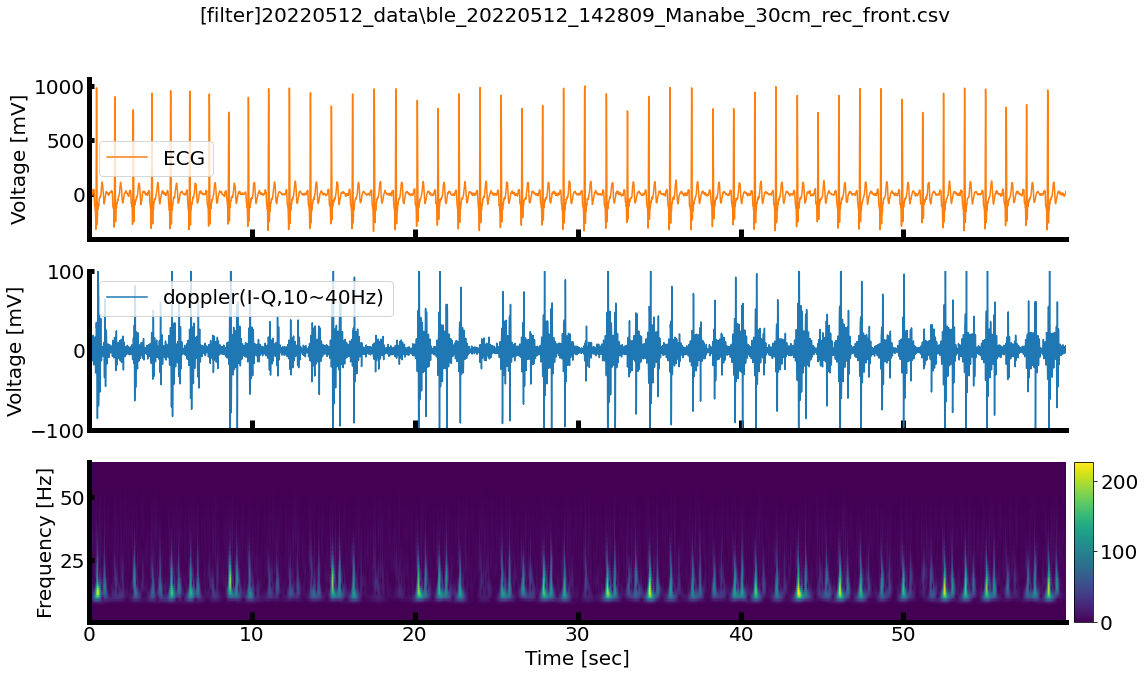

wave.shape=(144, 7680), len(freq)=144, freqs=(39.02785103463705, 10.337141955837549)
0番目：J=74.15890908017921, ECGのRピーク値=986.8195101090706, wave.shape=(76, 145), len(freq)=76, freqs=(39.02785103463705, 10.337141955837549)
1番目：J=73.91845604134068, ECGのRピーク値=904.137769911706, wave.shape=(75, 143), len(freq)=75, freqs=(39.02785103463705, 10.337141955837549)
2番目：J=74.5134403875474, ECGのRピーク値=783.3100634463221, wave.shape=(76, 148), len(freq)=76, freqs=(39.02785103463705, 10.337141955837549)
3番目：J=74.27789470656022, ECGのRピーク値=935.8644803645644, wave.shape=(76, 146), len(freq)=76, freqs=(39.02785103463705, 10.337141955837549)
4番目：J=74.86085687190095, ECGのRピーク値=960.902946971004, wave.shape=(76, 151), len(freq)=76, freqs=(39.02785103463705, 10.337141955837549)
5番目：J=75.08865411231183, ECGのRピーク値=956.9393446002541, wave.shape=(77, 153), len(freq)=77, freqs=(39.02785103463705, 10.337141955837549)
6番目：J=75.08865411231183, ECGのRピーク値=930.3671817580624, wave.shape=(77, 153), len(freq)=77, freqs=(39.02

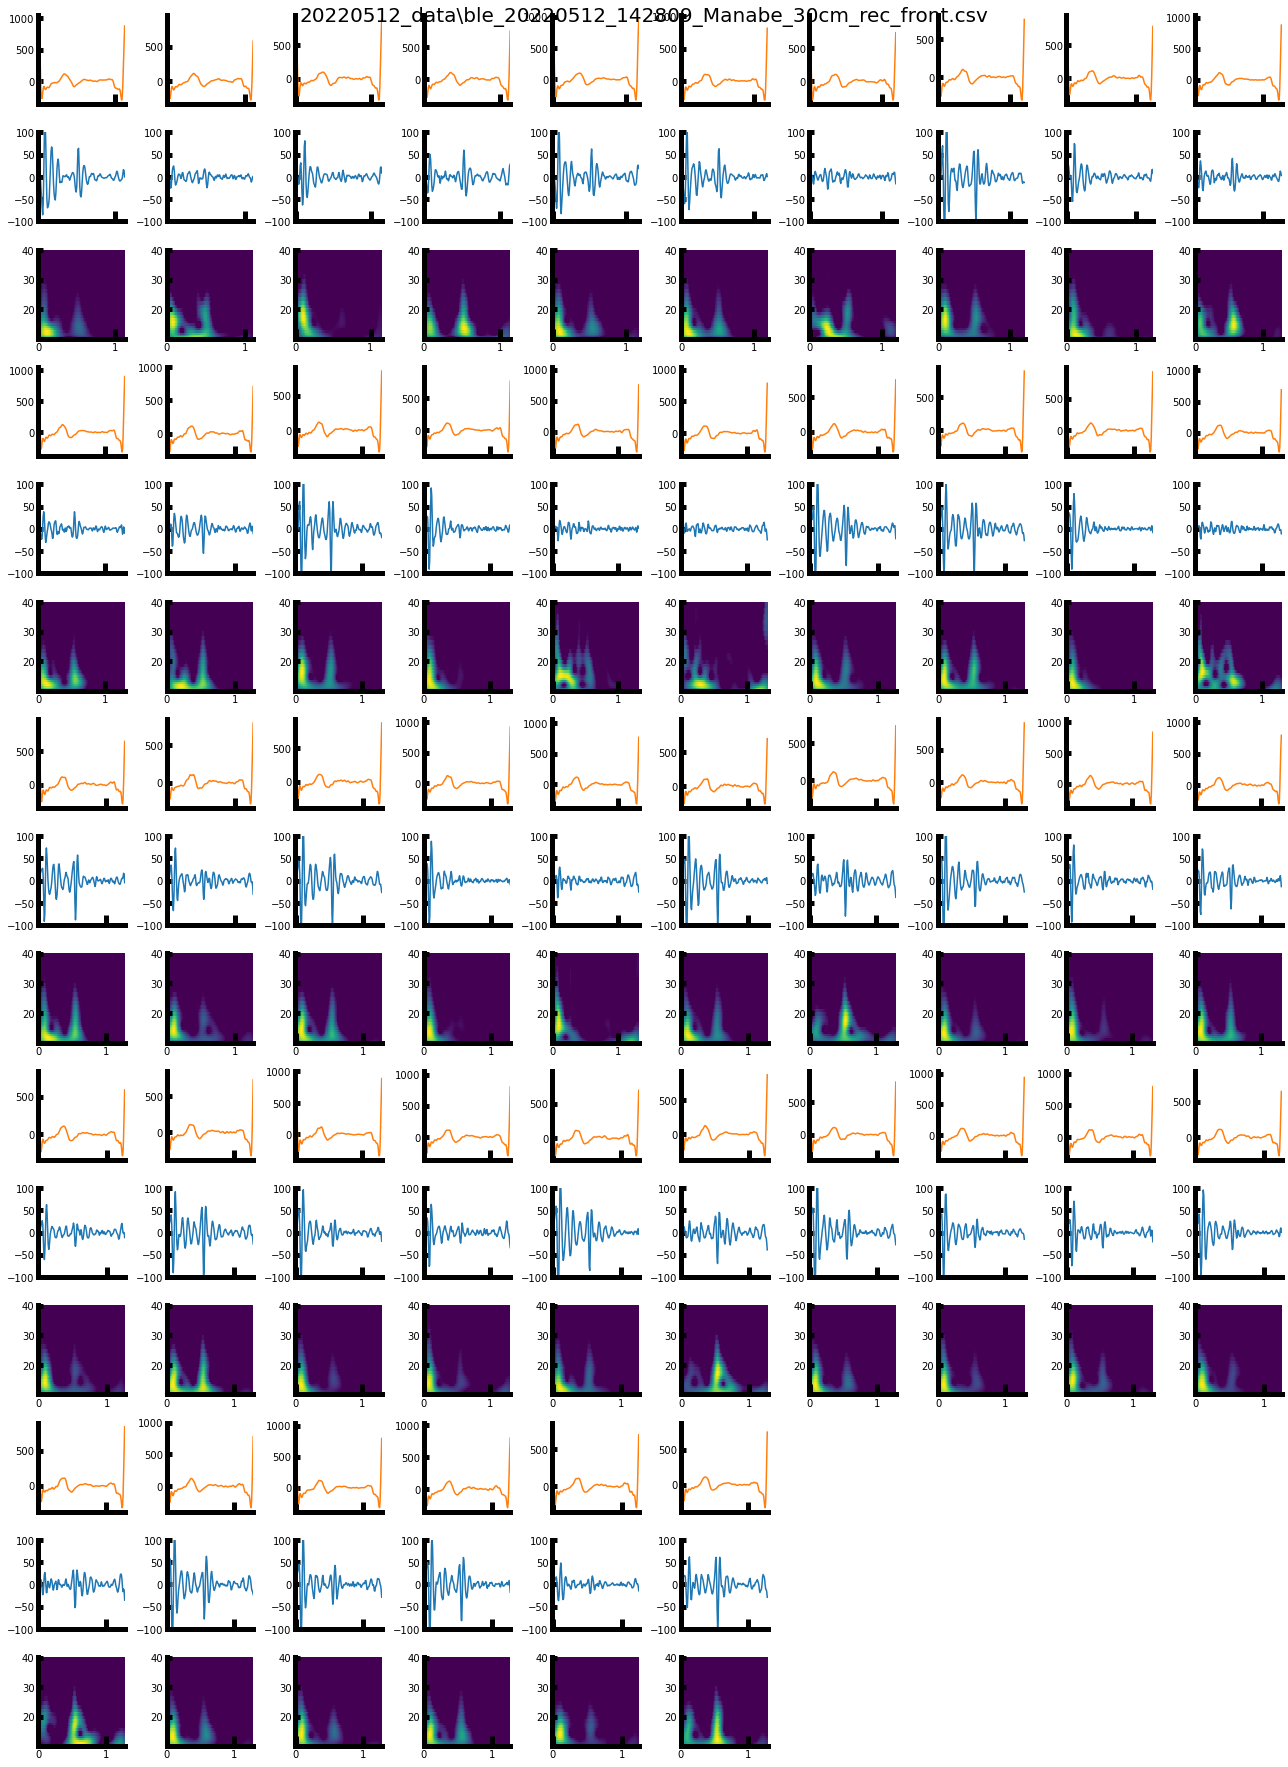

20220512_data\ble_20220512_143052_Manabe_50cm_rec_front.csv


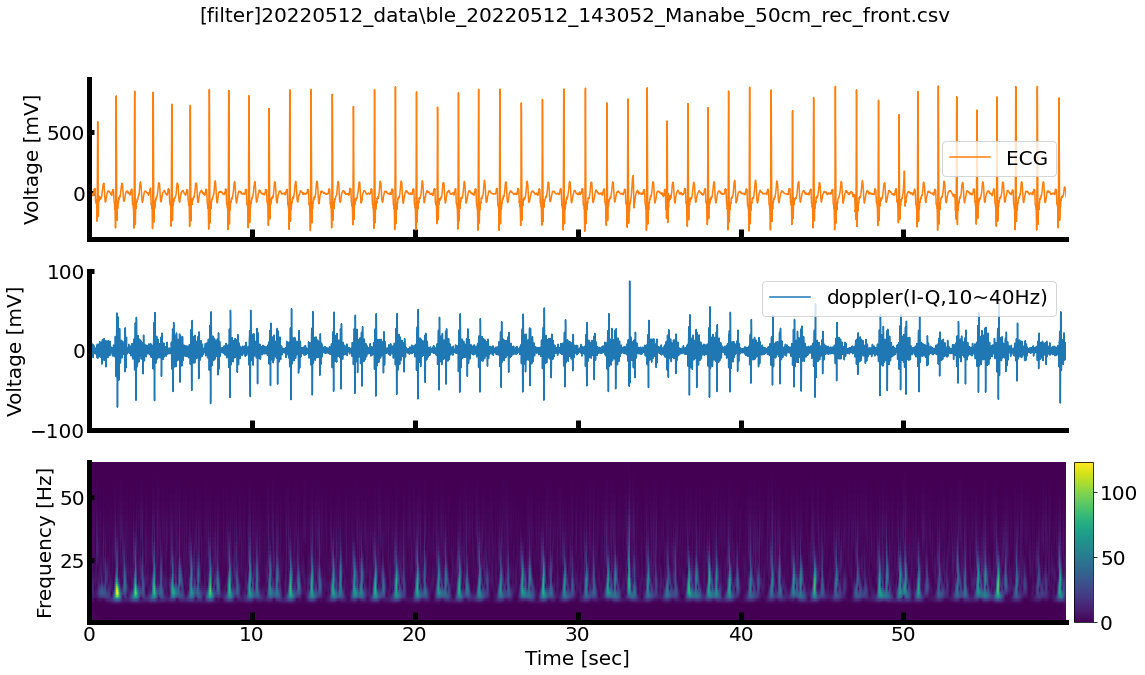

wave.shape=(144, 7680), len(freq)=144, freqs=(39.02785103463705, 10.337141955837549)
0番目：J=74.27789470656022, ECGのRピーク値=588.5524969154036, wave.shape=(76, 146), len(freq)=76, freqs=(39.02785103463705, 10.337141955837549)
1番目：J=74.15890908017921, ECGのRピーク値=800.0706520767526, wave.shape=(76, 145), len(freq)=76, freqs=(39.02785103463705, 10.337141955837549)
2番目：J=74.15890908017921, ECGのRピーク値=837.5335474503343, wave.shape=(76, 145), len(freq)=76, freqs=(39.02785103463705, 10.337141955837549)
3番目：J=74.27789470656022, ECGのRピーク値=829.6180228258418, wave.shape=(76, 146), len(freq)=76, freqs=(39.02785103463705, 10.337141955837549)
4番目：J=74.27789470656022, ECGのRピーク値=731.5746596107147, wave.shape=(76, 146), len(freq)=76, freqs=(39.02785103463705, 10.337141955837549)
5番目：J=74.63002224554594, ECGのRピーク値=722.1473955955325, wave.shape=(76, 149), len(freq)=76, freqs=(39.02785103463705, 10.337141955837549)
6番目：J=75.08865411231183, ECGのRピーク値=852.1595369927564, wave.shape=(77, 153), len(freq)=77, freqs=(39

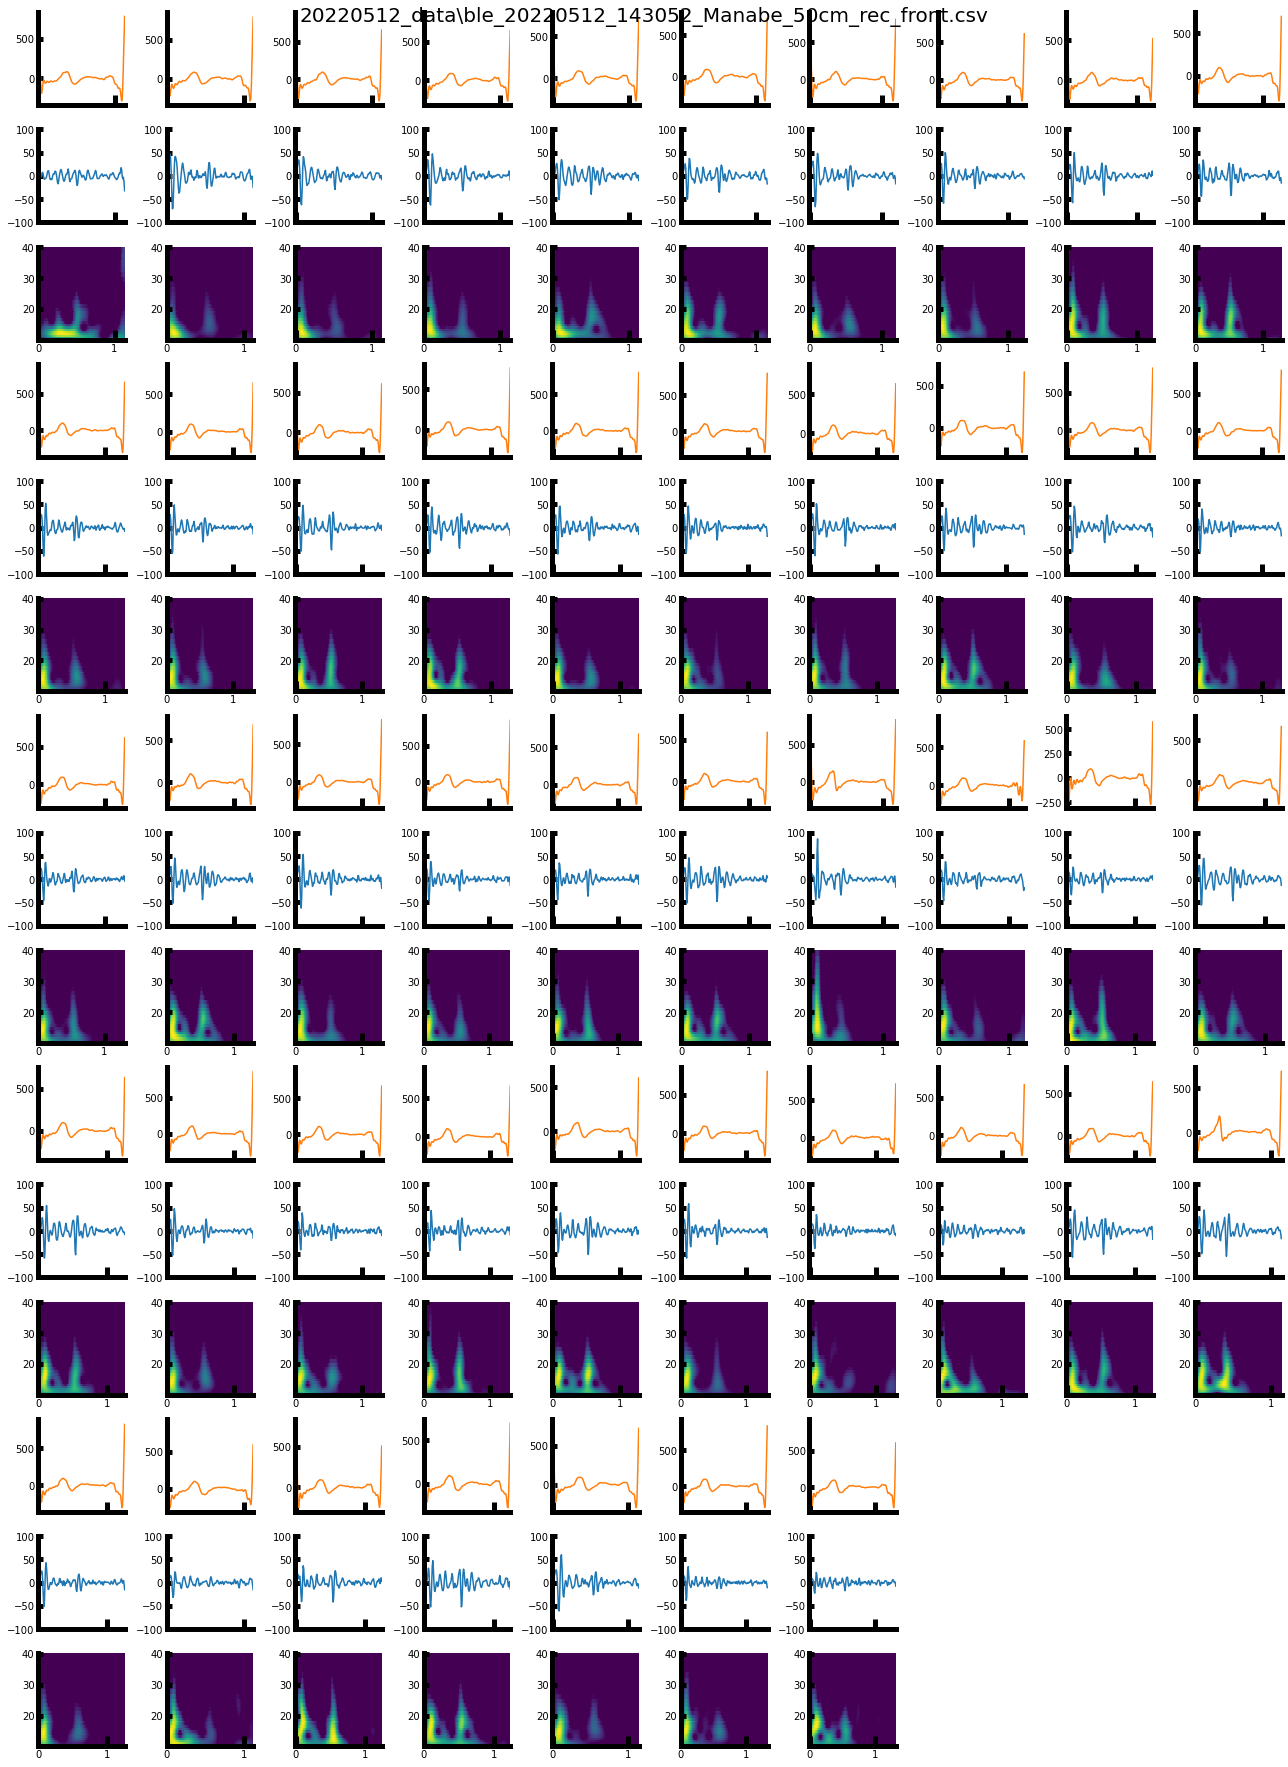

In [23]:
# ----- パラメータ

# 分割手法
DIST_MODE_LIST = ['PrePost','IBI']
DIST_MODE = DIST_MODE_LIST[1]

pre_sec, post_sec = 0.2, 0.6 # ピーク前後指定した秒数で分割する場合に用いるパラメータ

START_SEC = 5 # 何秒から見るか
DURATION_SEC = 60 # 何秒間見るか

lpf_fp = 40
lpf_fs = 42
hpf_fp = 10
hpf_fs = 8

sma_num = 5

cmap = plt.cm.viridis

# --------------------------------------------------------------------------------------- #
data_dir_path = "./20220512_data/"
path_gen = Path(data_dir_path).glob("*.csv")

# ファイル読み込み
for fname in path_gen:
    fname = str(fname)
    print(fname)

    BLUETOOTH_MODE = True if "ble" in fname else False

    # 有線かBluetoothかどうかでパラメータを変える必要がある
    ch_num = 2 if BLUETOOTH_MODE else 7 # 計測データのチャネル数
    fs_org = 256 if BLUETOOTH_MODE else 500 # 計測時のサンプリングレート
    fs_ds = 128 if BLUETOOTH_MODE else 125 # ダウンサンプリング後のサンプリングレート
    thinning_num = 2 if BLUETOOTH_MODE else 4 # ダウンサンプリングでデータを間引くサンプル間隔

    dt_org = 1/fs_org
    dt_ds = 1/fs_ds

    start_sample = START_SEC*fs_org
    end_sample = (START_SEC+DURATION_SEC)*fs_org

    # 分割パラメータ
    pre_sample_num, post_sample_num = int(pre_sec*fs_ds), int(post_sec*fs_ds)

    wave_fp = codecs.open(fname, 'r')

# ----- csvから2次元listへ
    times = []
    ch = []
    for i in range(ch_num):
        ch.append([])
    for idx2, line in enumerate(wave_fp):
        split_data = line.rstrip('\r\n').split(',')
        times.append(idx2)
        for i in range(ch_num):
            ch[i].append(int(float(split_data[i])))
    wave_fp.close()

# ----- 各信号（ECG/Doppler）を変数に格納
    ecg = ch[0][start_sample:end_sample] # ECG
    # doppler
    if BLUETOOTH_MODE:
        doppler = ch[-1][start_sample:end_sample]
    else:
        # i_1st = ch[1]
        i_2nd = ch[2]
        # q_1st = ch[3]
        q_2nd = ch[4]
        # iq_diff_1st = [i-q for (i,q) in zip(i_1st, q_1st)]
        iq_diff_2nd = [i-q for (i,q) in zip(i_2nd, q_2nd)]
        doppler = iq_diff_2nd[start_sample:end_sample]

# ----- フィルタ前プロット
    # time_array = np.arange(0,len(ecg))*dt_org # グラフ横軸（時間）
    # # CWT
    mother = pycwt.Morlet(6)
    # s0 = 2*dt_org # ウェーブレットの最小スケール。デフォルト値2dt。
    dj = 1/12 # 離散スケールの間隔。デフォルト値1/12。小さな値にするとスケール分解能が良くなるが、計算とプロットが遅くなる。
    # N = len(ecg) # サンプル点数
    # J =(math.log2(N * dt_org / s0))/dj # スケールの範囲s0からs0*2**(J*dj)までで、計(J+1)の尺度。

    # wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, dt_org, dj, s0, J, mother)

    # ecg_doppler_plot(time_array,ecg,doppler,wave,freqs,figtitle=f"[raw]{fname}")

# ----- 一つのグラフに心電図とドップラー両方表示したければこっち（twinx）
    # ax1 = fig.add_subplot(211)
    # ax1.plot(time_array,doppler,color='tab:blue')
    # plt.tick_params(labelsize=30)
    # ax2 = ax1.twinx()
    # ax2.plot(time_array,ecg,color='tab:orange')
    # plt.tick_params(labelsize=30)
    # fig.suptitle(fname, fontsize=30)

    ################################################################################
    #                                フィルタ                                      #
    ################################################################################

    # ECGのフィルタは多分これで確定でよい
    ecg = sig_proc.hpf(sig_proc.lpf(ecg, fs_org, fp=20, fs=25),fs_org,fp=3,fs=0.4)[::thinning_num]
    doppler = sig_proc.hpf(sig_proc.lpf(doppler,fs_org,fp=lpf_fp,fs=lpf_fs),fs_org,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    time_array = np.arange(0,len(ecg))*dt_ds # グラフ横軸（時間）

    # CWT
    s0 = 2*dt_ds # ウェーブレットの最小スケール。デフォルト値2dt。
    N = len(ecg) # サンプル点数
    J =(math.log2(N * dt_ds / s0))/dj # スケールの範囲s0からs0*2**(J*dj)までで、計(J+1)の尺度。
    wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, dt_ds, dj, s0, J, mother)
    ecg_doppler_plot(time_array,ecg,doppler,wave,freqs,doppler_filter=True,filter_l=hpf_fp,filter_h=lpf_fp,figtitle=f"[filter]{fname}",savefig=True,figpath=f"{fname.replace('.csv','')}_filtered.png")

    print(f"wave.shape={wave.shape}, len(freq)={len(freqs)}, freqs={freqs[8], freqs[31]}")

    chnp = []
    chnp.append(np.array(ecg))
    chnp.append(np.array(doppler))
    data = np.vstack([chnp[0],chnp[1]])

    ################################################################################
    #                                　分割　                                      #
    ################################################################################

# ----- 時系列探索でPPGピーク検出＆分割
    # peak_times, peak_vals = sig_proc.peak_search(sig_proc.min_max(ecg), fs_ds)
    peak_times, peak_vals = sig_proc.peak_search(ecg, fs_ds)
    data_dist = dist_HR(data, peak_times, peak_vals, mode=DIST_MODE, pre_sample_num=pre_sample_num, post_sample_num=post_sample_num)
    npeaks = len(data_dist)

# ----- 分割プロット
    if npeaks <= 10:
        nrow = 3
        ncol = npeaks
    else:
        ncol = 10
        nrow = -(-npeaks // ncol) * 3 # 切り上げ

    fig = plt.figure(figsize=(18,5*nrow/3))

    # 時系列波形
    for peak_idx in range(npeaks):
        if peak_idx == 0 or peak_idx >= 13:
            # continue
            pass

        ecg = data_dist[peak_idx][0]
        doppler = data_dist[peak_idx][1]

        N = len(ecg) # サンプル点数
        time_array = np.arange(0,N)*dt_ds # グラフ横軸（時間）

        # CWT
        J =(math.log2(N * dt_ds / s0))/dj # スケールの範囲s0からs0*2**(J*dj)までで、計(J+1)の尺度。
        wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, dt_ds, dj, s0, J, mother)

        if DIST_MODE == DIST_MODE_LIST[1]:
            print(f"{peak_idx}番目：J={J}, ECGのRピーク値={ecg[0]}, wave.shape={wave.shape}, len(freq)={len(freqs)}, freqs={freqs[8], freqs[31]}")

        wave_lim = wave[8:32,:]
        freqs_lim = freqs[8:32]

        # ECG
        ax1 = fig.add_subplot(nrow,ncol,peak_idx+(peak_idx//ncol)*2*ncol+1)
        ax1.plot(time_array, ecg, color='tab:orange')

        # doppler(time)
        ax2 = fig.add_subplot(nrow,ncol,peak_idx+(peak_idx//ncol)*2*ncol+ncol+1, sharex=ax1)
        ax2.set_ylim([-100,100])
        ax2.plot(time_array, doppler, color='tab:blue')

        # doppler(CWT)
        ax3 = fig.add_subplot(nrow,ncol,peak_idx+(peak_idx//ncol)*2*ncol+2*ncol+1, sharex=ax1)
        # ax3.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
        ax3.pcolormesh(time_array, freqs_lim, sig_proc.zscore(np.abs(wave_lim)), vmin=0, shading='auto')
        # ax3.set_ylabel('Frequency [Hz]')
        # ax3.set_xlabel('Time [sec]')
        #ax.set_ylim([3, 50])

        # x軸共有のため、上二つのラベルは非表示にする
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax2.get_xticklabels(), visible=False)

        # 右と上の枠線を消すcf)https://qiita.com/irs/items/fe909442be057f0efb48
        for ax in [ax1, ax2, ax3]:
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_linewidth(5)
            ax.spines['bottom'].set_linewidth(5)
            ax.xaxis.set_tick_params(direction='in',bottom=True,top=False,left=False,right=False,length=10,width=5)
            ax.yaxis.set_tick_params(direction='in',bottom=True,top=False,left=False,right=False,length=5,width=5)

    fig.suptitle(fname, fontsize=20)
    fig.tight_layout()
    fig.savefig(f"{fname.replace('.csv','')}_split.png")
    plt.show()

In [9]:
import os
from pptx import Presentation
from PIL import Image
from glob import glob

In [24]:
prs = Presentation()

#スライドサイズ取得
SLIDE_WIDTH, SLIDE_HEIGHT = prs.slide_width, prs.slide_height
#スライド中心のX,Y座標（左上が原点）
IMG_CENTER_X, IMG_CENTER_Y = SLIDE_WIDTH/2, SLIDE_HEIGHT/2

# レイアウトテンプレート6番（白紙）
# レイアウトテンプレート5番（タイトルあり白紙）
blank_slide_layout = prs.slide_layouts[6]

# 画像ファイルの読み込み
fnms = glob(r'.\20220512_data\*.png')
fnms.sort()

# 1枚/ページ
for fnm in fnms:
    # 白紙のスライドの追加
    slide = prs.slides.add_slide(blank_slide_layout)
    # スライドタイトル
    title = slide.shapes.add_textbox(0,0,width=SLIDE_WIDTH,height=SLIDE_HEIGHT/6)
    # title.text = "No." + str(os.path.split(fnm)[1][0:2])
    title.text = str(fnm)
    # # 画像情報取得
    # im = Image.open(fnm)
    # im_width, im_height = im.size
    # # センタリング
    # left = int(IMG_CENTER_X - im_width / 2)
    # top  = int(IMG_CENTER_Y - im_height / 2)
    # 画像貼り付け
    #pic = slide.shapes.add_picture(fnm, left, top, width = im_width, height=im_height)
    pic = slide.shapes.add_picture(fnm, 0, top = SLIDE_HEIGHT/10, width=SLIDE_WIDTH, height=SLIDE_HEIGHT-SLIDE_HEIGHT/10)

#print(IMG_CENTER_X, IMG_CENTER_Y)


# # 3x3枚/ページ
# pict_layout = [3, 3]#x, y
# pict_per_page = pict_layout[0] * pict_layout[1]
# for idx, fnm in enumerate(fnms):
#     if idx % (pict_per_page) == 0:

#         slide = prs.slides.add_slide(blank_slide_layout)
#     pic = slide.shapes.add_picture(fnm, 0, 0, height=(height / pict_layout[1]))
#     pic.left = int(width / pict_layout[0] * int(idx % pict_layout[0]))
#     pic.top  = int(height / pict_layout[1] * int((idx % pict_per_page) / pict_layout[1]))
#     #print("{0}, {1}, {2}, {3}".format(width / pict_layout[0], height / pict_layout[1], pic.left, pic.top))

# 名前をつけて保存
prs.save(r'.\20220512_data\result.pptx')